<a href="https://colab.research.google.com/github/hamed-sdz/public/blob/main/New_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q finpy-tse

# import finpy_tse as fpy

# df = fpy.Get_CWI_History(
#     start_date='1390-01-01',
#     end_date='1402-03-15',
#     ignore_date=False,
#     just_adj_close=False,
#     show_weekday=False,
#     double_date=False)

# df.to_csv('tse.csv', sep=',')

In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, LeakyReLU, Flatten, Lambda
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import sklearn.metrics as sklearn_metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVR

np.random.seed(0)

# Data Loading

In [3]:
def dataframe_extend(dataframe):
    ma_window = 5
    for i in range(dataframe.shape[0] - ma_window):

        s = 0
        for j in range(ma_window):
            s += dataframe.iloc[i + j, 3]
        dataframe.loc[dataframe.index[i + ma_window], 'Ma'] = np.round(s / ma_window, 6)

        target = np.log(dataframe.iloc[i + 1, 3] / dataframe.iloc[i, 3])
        dataframe.loc[dataframe.index[i], 'Target'] = np.round(target, 6)

    return dataframe[ma_window:-ma_window]


DataFrame = pd.read_csv('tse.csv')
DataFrame = DataFrame.drop(columns=['J-Date'])
DataFrame = DataFrame.drop(columns=['Volume'])
DataFrame = DataFrame.drop(columns=['Adj Close'])
DataFrame = dataframe_extend(DataFrame)

In [4]:
DataFrame.head()

,Open,High,Low,Close,Ma,Target
5,24498.0,24590.0,24498.0,24544.0,24243.4,0.019328
6,24553.0,25023.0,24553.0,25023.0,24401.0,0.020842
7,25035.0,25550.0,25035.0,25550.0,24565.6,0.013026
8,25556.0,25885.0,25556.0,25885.0,24818.0,0.012973
9,25908.0,26272.0,25908.0,26223.0,25097.6,-0.008425


In [5]:
DataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2924.0,443126.505472,610480.786063,0.000000,64038.250000,80980.500000,934342.500000,2.548220e+06
High,2924.0,446325.700752,614402.730865,23852.000000,64349.250000,81258.000000,966604.750000,2.548220e+06
Low,2924.0,441675.939808,607408.390579,23768.000000,64040.000000,80929.000000,934342.500000,2.527540e+06
Close,2924.0,444093.043092,611008.347591,23787.000000,64189.750000,81124.000000,957110.000000,2.535236e+06
Ma,2924.0,441732.803762,608033.410476,23924.800000,64064.350000,80974.300000,922082.350000,2.505644e+06
Target,2924.0,0.001546,0.011314,-0.056704,-0.003172,0.000554,0.005694,4.842200e-02


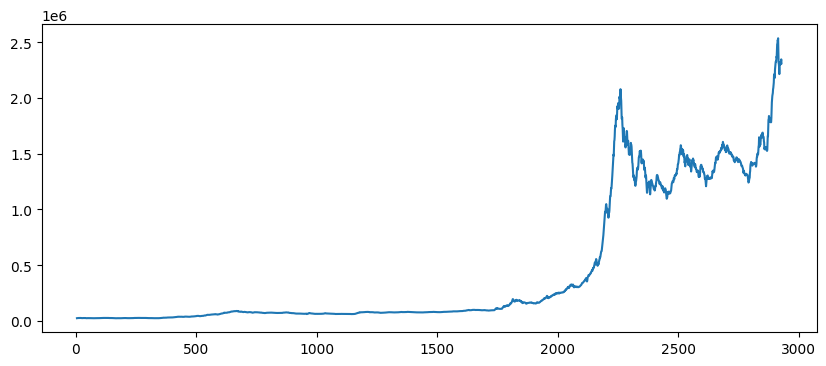

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(DataFrame['Close'])
plt.show()

# Preprocessing

In [7]:
class Standarized_TimeseriesGenerator(TimeseriesGenerator):
    def __getitem__(self, index):
        samples, goals = super(Standarized_TimeseriesGenerator, self).__getitem__(index)

        samples_t = samples[:, :, -1]
        goals_t = goals[:, -1]

        samples_t = samples_t.reshape(samples_t.shape[0], samples_t.shape[1], 1)
        goals_t = goals_t.reshape(goals_t.shape[0], 1)

        samples = samples[:, :, :-1]
        goals = goals[:, :-1]

        avg = samples.mean(axis=1)
        st = samples.std(axis=1)
        samples = (samples - avg[:, None, :]) / st[:, None, :]
        goals = (goals - avg) / st

        samples = np.append(samples, samples_t, axis=2)
        goals = np.append(goals, goals_t, axis=1)

        return samples, goals


def get_data_gen(dataset):
    data_gen_training = Standarized_TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=0, end_index=train_size, shuffle=True)
    data_gen_testing = Standarized_TimeseriesGenerator(
        dataset, dataset, length=n_sequence, sampling_rate=1, stride=1, batch_size=n_batch,
        start_index=train_size, end_index=dataset.shape[0] - 1)
    return data_gen_training, data_gen_testing


def collect_all(data_gen):
    x_list = []
    y_list = []
    for i in range(len(data_gen)):
        x, y = data_gen[i]
        x_list.append(x)
        y_list.append(y)
    return np.concatenate(x_list), np.concatenate(y_list)


In [8]:
dataset = DataFrame.to_numpy()

n_sequence = 10
n_features = len(DataFrame.columns)
n_batch = 256
n_epochs = 1000
train_size = int(dataset.shape[0] * 0.8)

data_gen_train, data_gen_test = get_data_gen(dataset)

X_train, Y_train = collect_all(data_gen_train)
X_test, Y_test = collect_all(data_gen_test)

# Visualization Utilities

In [9]:
def plot_gan_history(history, history_val, metrics):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(25, 14))

    i = 0
    for n, metric_name in enumerate(metrics):
        a = axs[i // 3, i % 3]
        a.set_title(metric_name)
        a.plot(history[n], label='train')
        a.plot(history_val[n], label='test')
        a.legend()
        i += 1

    for j in range(i, 9):
        fig.delaxes(axs[j // 3, j % 3])

    plt.show()


def plot_history(history, metrics):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(25, 14))

    i = 0
    for m, metric_name in enumerate(metrics):
        a = axs[i // 3, i % 3]
        a.set_title(metric_name)
        a.plot(history[metric_name], label='train')
        a.plot(history['val_' + metric_name], label='test')
        i += 1

    for j in range(i, 9):
        fig.delaxes(axs[j // 3, j % 3])

    plt.show()


def get_metrics(y_true, y_pred):
    metrics = {}
    metrics['mse'] = sklearn_metrics.mean_squared_error(y_true, y_pred)
    metrics['mae'] = sklearn_metrics.mean_absolute_error(y_true, y_pred)
    metrics['mape'] = sklearn_metrics.mean_absolute_percentage_error(y_true, y_pred)
    metrics['rmse'] = np.sqrt(metrics['mse'])

    # mask = np.array(y_pred[1:] > y_pred[:-1], dtype='float32')
    # ar = np.mean((y_true[1:] - y_true[:-1]) * mask)

    N = len(y_true)
    ar = np.sum(np.max(y_true - y_pred, 0)) / (N - 1)

    metrics['ar'] = ar

    return metrics


def model_result(model: Model):
    prediction = model.predict(X_test, verbose=0)
    y_true = Y_test[:, 5]
    y_pred = prediction[:, 5]

    metrics = get_metrics(y_true, y_pred)

    print('mse: ', metrics['mse'])
    print('mae: ', metrics['mae'])
    print('mape: ', metrics['mape'])
    print('rmse: ', metrics['rmse'])
    print('ar: ', metrics['ar'])

    plt.figure(figsize=(10, 4))
    # plt.grid(True)
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

    return y_pred, metrics


# Metrics

In [10]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:, 5] - y_pred[:, 5]))


def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 5] - y_pred[:, 5])))


def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 5] - y_pred[:, 5]) / y_true[:, 5]))


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:, 5] - y_pred[:, 5])))


# def ar(y_true, y_pred):
#     mask = tf.cast(y_pred[1:, 5] > y_pred[:-1, 5], tf.float32)
#     return tf.reduce_mean((y_true[1:, 5] - y_true[:-1, 5]) * mask)

def ar(y_true, y_pred):
    N = tf.cast(tf.size(y_true[:, 5]), tf.float32)
    return tf.keras.backend.sum(tf.keras.backend.maximum(y_true[:, 5] - y_pred[:, 5], 0)) / (N - 1)


# GAN

In [11]:
# ======================================================================================================================
#                                       GAN Model
# ======================================================================================================================

def make_generator_model():
    inputs = Input(shape=(n_sequence, n_features,))
    lstm_1 = LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=20, return_sequences=False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2 = tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    return model


def make_discriminator_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence + 1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model


def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(x, y, fake_output):
    a1 = 0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1 * g_mse + (1 - a1) * g_loss, g_mse


def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)
        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)
        gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)


def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)
    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)
    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)
    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)


def train(dataset, dataset_val, ep):
    h = np.empty(shape=(8, ep))
    hv = np.empty(shape=(8, ep))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(ep):
        start = time.time()
        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0] / len_dataset
            cur_dis_loss += aux_cur_losses[1] / len_dataset
            cur_gen_mse_loss += aux_cur_losses[2] / len_dataset
        cur_gen_metrics = generator.evaluate(dataset, verbose=False)[1:]
        h[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
        cur_gen_metrics_val = generator.evaluate(dataset_val, verbose=False)[1:]
        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0] / len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1] / len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2] / len_dataset_val
        hv[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val
        print('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
            .format(epoch + 1, time.time() - start, cur_gen_loss, cur_dis_loss))
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    return h, hv


@tf.function
def train_step(sequences, sequences_end):
    return train_step_def(sequences, sequences_end)


@tf.function
def test_step(sequences, sequences_end):
    return test_step_def(sequences, sequences_end)


In [12]:
# ======================================================================================================================
#                                       Train GAN Model
# ======================================================================================================================

learning_rate = 1e-3
epochs = n_epochs

generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
checkpoint_dir = 'checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

history, history_val = train(data_gen_train, data_gen_test, epochs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 10)            680       
                                                                 
 batch_normalization (BatchN  (None, 10, 10)           40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 10)            0         
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                2480      
                                                             

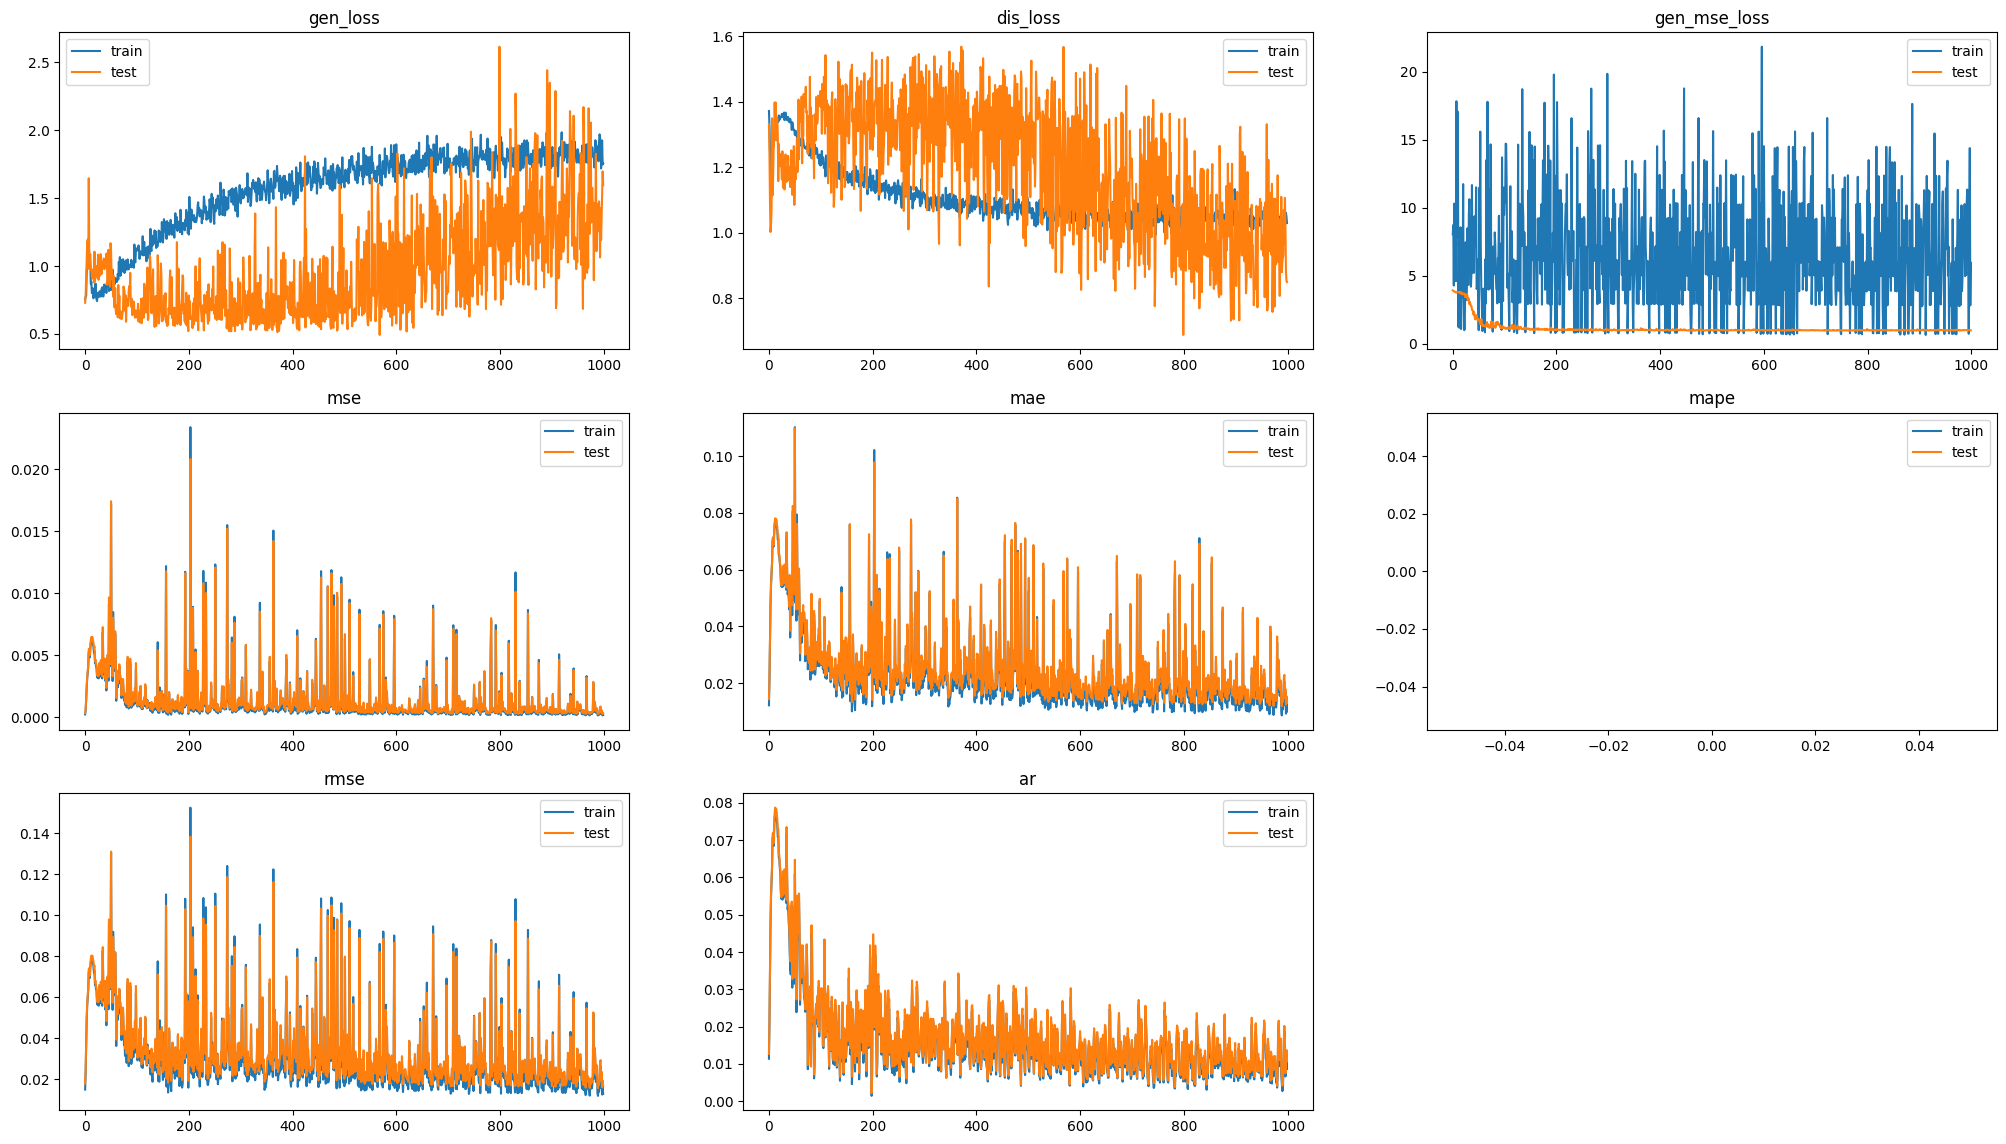

3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 2.9643e-04 - mae: 0.0130 - mape: inf - rmse: 0.0167 - ar: 0.0107


,0
loss,1.594579
mse,0.000296
mae,0.012954
mape,inf
rmse,0.016738
ar,0.010667


In [13]:
metrics = ["gen_loss", "dis_loss", "gen_mse_loss", 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_gan_history(history, history_val, metrics)

GAN_evaluation = generator.evaluate(data_gen_test)
GAN_evaluation[0] = history_val[0][-1]
df = pd.DataFrame(data=GAN_evaluation, index=['loss', 'mse', 'mae', 'mape', 'rmse', 'ar'])
df.head(len(df))


mse:  0.00022940703638331812
mae:  0.011541295790057133
mape:  11920524722.358953
rmse:  0.015146188840210534
ar:  0.00010258915935005045


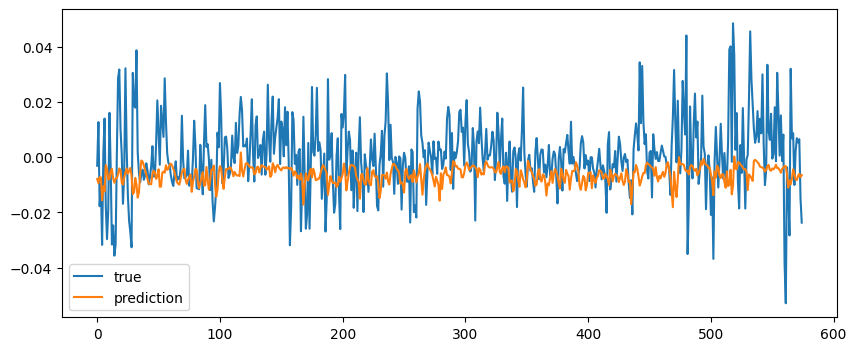

In [14]:
y_pred_GAN, metrics_GAN = model_result(generator)


# SVR

In [15]:
# ======================================================================================================================
#                                       Train SVR Model And Train
# ======================================================================================================================

def SVR_model():
    return SVR(kernel='rbf', C=1e4, gamma=1e-5)


x_train = X_train[:, :, -1]
y_train = Y_train[:, -1]

x_test = X_test[:, :, -1]
y_test = Y_test[:, -1]

x_train = x_train.reshape((x_train.shape[0], n_sequence))
x_test = x_test.reshape((x_test.shape[0], n_sequence))

model_SVR = SVR_model()

model_SVR.fit(x_train, y_train)
pred_SVR = model_SVR.predict(x_test)


mse:  0.00023097555821739127
mae:  0.011621177391304345
mape:  53314787246.65703
rmse:  0.01519788005668525
ar:  9.621777003484321e-05


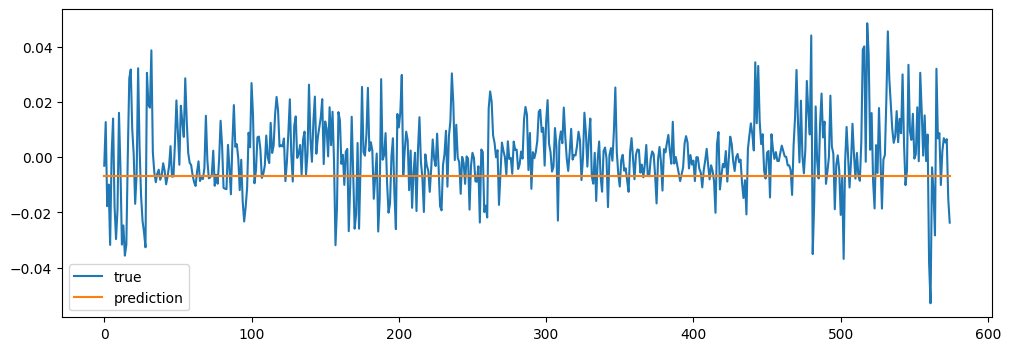

In [16]:
y_true = y_test
y_pred = pred_SVR
y_pred_SVR = y_pred

metrics_SVR = get_metrics(y_true, y_pred)

print('mse: ', metrics_SVR['mse'])
print('mae: ', metrics_SVR['mae'])
print('mape: ', metrics_SVR['mape'])
print('rmse: ', metrics_SVR['rmse'])
print('ar: ', metrics_SVR['ar'])

plt.figure(figsize=(12, 4))
plt.plot(y_true, label="true")
plt.plot(y_pred, label="prediction")
plt.legend()
plt.show()


# LSTM

In [17]:
# ====================================================================================================================
#                                       LSTM Model
# ====================================================================================================================

def LSTM_Model():
    inputs = Input(shape=(n_sequence, n_features))
    lstm_1 = tf.keras.layers.LSTM(10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.1)(lstm_1_LRelu)
    lstm_2 = tf.keras.layers.LSTM(20, return_sequences=False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2 = tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_droput = Dropout(0.1)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='mse', optimizer='adam', metrics=[mse, mae, mape, rmse, ar])

    return model

In [18]:
# ======================================================================================================================
#                                       Train LSTM Model
# ======================================================================================================================

model_LSTM = LSTM_Model()
model_LSTM.summary()

history_LSTM = model_LSTM.fit(data_gen_train, validation_data=data_gen_test, epochs=n_epochs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 10)            680       
                                                                 
 batch_normalization_2 (Batc  (None, 10, 10)           40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 10, 10)            0         
                                                                 
 dropout_5 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                2480      
                                                           

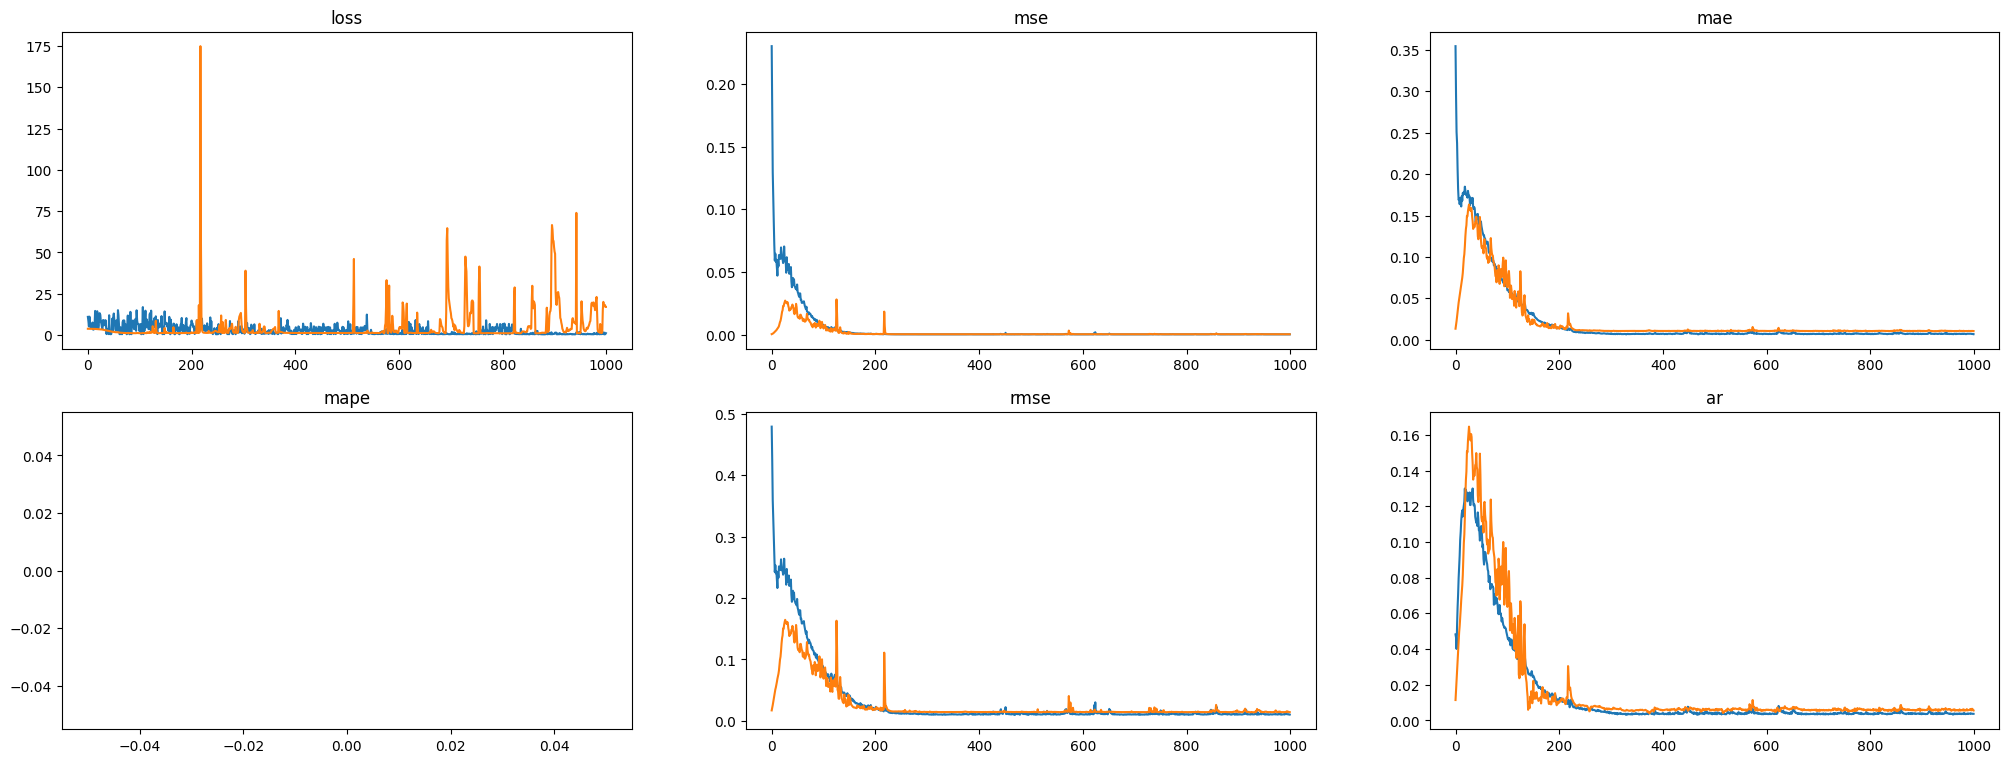

3/3 [==============================] - 0s 6ms/step - loss: 16.9986 - mse: 2.1531e-04 - mae: 0.0106 - mape: inf - rmse: 0.0142 - ar: 0.0056


,0
loss,16.998621
mse,0.000215
mae,0.010588
mape,inf
rmse,0.014232
ar,0.005575


In [19]:
metrics = ['loss', 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_history(history_LSTM.history, metrics)

LSTM_evaluation = model_LSTM.evaluate(data_gen_test)
df = pd.DataFrame(data=LSTM_evaluation, index=metrics)
df.head(len(df))


mse:  0.00016638235704824922
mae:  0.00947888559414153
mape:  16911774745.388742
rmse:  0.012898928523263055
ar:  7.892658346927747e-05


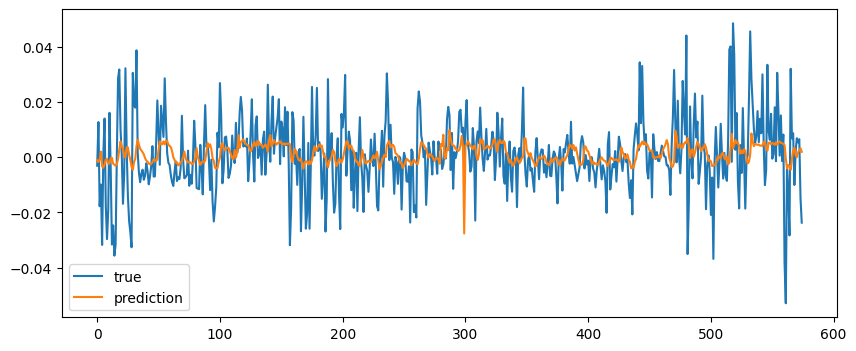

In [20]:
y_pred_LSTM, metrics_LSTM = model_result(model_LSTM)


# ANN

In [21]:
# ======================================================================================================================
#                                       ANN Model
# ======================================================================================================================

def ANN_Model():
    model = Sequential()
    model.add(Input(shape=(n_sequence, n_features)))
    model.add(Flatten())
    model.add(Dense(units=72, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    # model.add(Dropout(0.4))
    model.add(Dense(units=100, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(Dropout(0.4))
    model.add(Dense(units=10, activation='relu', kernel_initializer='random_normal'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # model.add(Dropout(0.2))
    model.add(Dense(units=n_features, activation=None))
    model.add(LeakyReLU(alpha=0.3))

    model.compile(loss='mse', optimizer='adam', metrics=[mse, mae, mape, rmse, ar])

    return model


In [22]:
# ======================================================================================================================
#                                       Train ANN Model
# ======================================================================================================================

model_ANN = ANN_Model()
model_ANN.summary()

history_ANN = model_ANN.fit(data_gen_train, validation_data=data_gen_test, epochs=n_epochs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 72)                4392      
                                                                 
 dense_7 (Dense)             (None, 100)               7300      
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
 dense_9 (Dense)             (None, 6)                 66        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6)                 0         
                                                                 
Total params: 12,768
Trainable params: 12,768
Non-trai

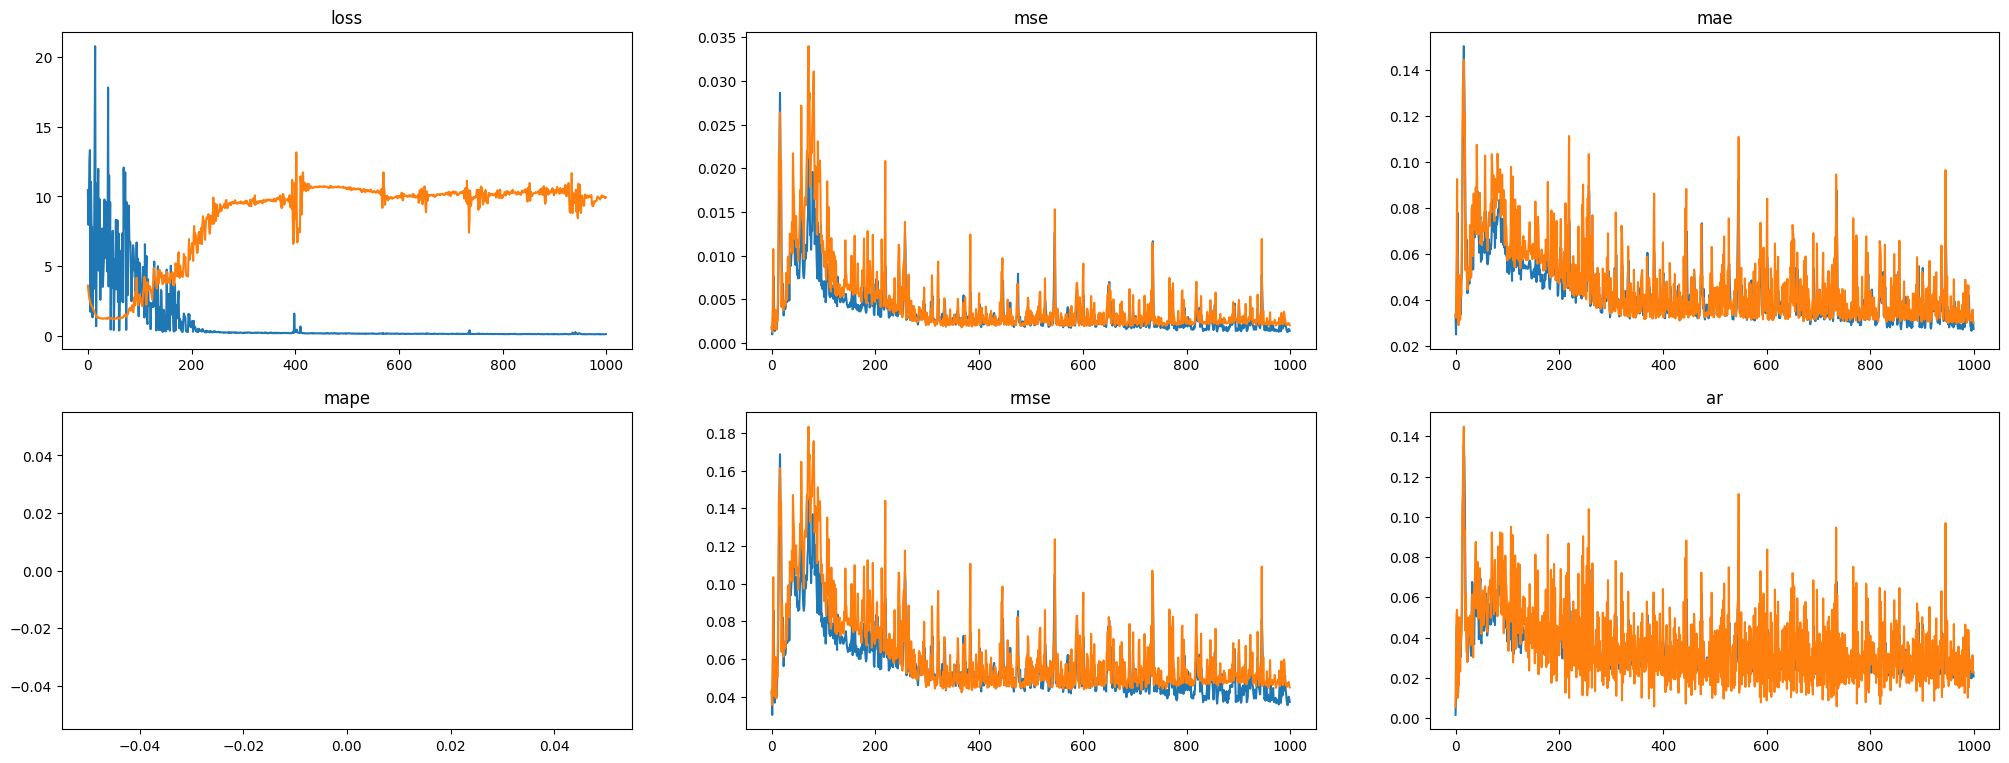

3/3 [==============================] - 0s 7ms/step - loss: 9.9469 - mse: 0.0020 - mae: 0.0299 - mape: inf - rmse: 0.0448 - ar: 0.0228


,0
loss,9.946920
mse,0.002035
mae,0.029946
mape,inf
rmse,0.044839
ar,0.022812


In [23]:
metrics = ['loss', 'mse', 'mae', 'mape', 'rmse', 'ar']
plot_history(history_ANN.history, metrics)

ANN_evaluation = model_ANN.evaluate(data_gen_test)
df = pd.DataFrame(data=ANN_evaluation, index=metrics)
df.head(len(df))


mse:  0.0018629184566038186
mae:  0.02927513206276561
mape:  200625216855.73126
rmse:  0.04316153908984038
ar:  0.00038237810646116937


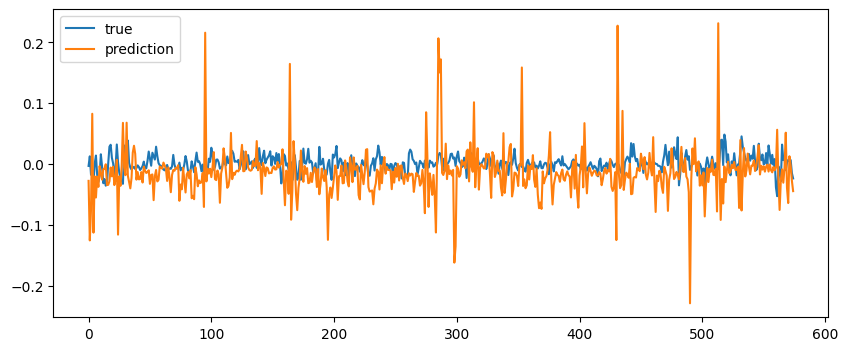

In [24]:
y_pred_ANN, metrics_ANN = model_result(model_ANN)


# Comparison

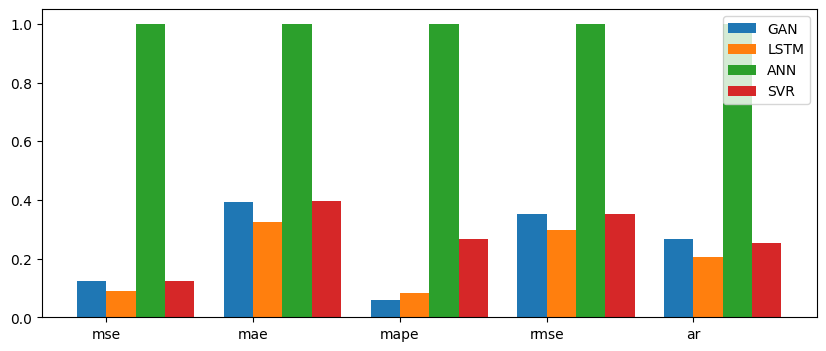

,GAN,LSTM,ANN,SVR
mse,0.123144,0.089313,1.0,0.123986
mae,0.394235,0.323786,1.0,0.396964
mape,0.059417,0.084295,1.0,0.265743
rmse,0.350919,0.298852,1.0,0.352116
ar,0.268292,0.206410,1.0,0.251630


In [25]:
# Comparing metrics

z = zip(metrics_GAN.values(), metrics_LSTM.values(), metrics_ANN.values(), metrics_SVR.values())
z = np.array(list(z), dtype='float32')
models_metrics = z

z = z.T
w = z / np.max(z, axis=0)

index = ['mse', 'mae', 'mape', 'rmse', 'ar']
columns = ['GAN', 'LSTM', 'ANN', 'SVR']

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(index))
bar_width = 0.2
for i in range(len(w)):
    ax.bar(x + i * bar_width, w[i], width=bar_width, label=columns[i])
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.show()

df = pd.DataFrame(data = w.T, index = index, columns = columns)
df.head(len(df))


In [26]:
df = pd.DataFrame(data = models_metrics, index = index, columns = columns)
df.head(len(df))

,GAN,LSTM,ANN,SVR
mse,2.294070e-04,1.663824e-04,1.862918e-03,2.309756e-04
mae,1.154130e-02,9.478886e-03,2.927513e-02,1.162118e-02
mape,1.192052e+10,1.691177e+10,2.006252e+11,5.331479e+10
rmse,1.514619e-02,1.289893e-02,4.316154e-02,1.519788e-02
ar,1.025892e-04,7.892658e-05,3.823781e-04,9.621777e-05


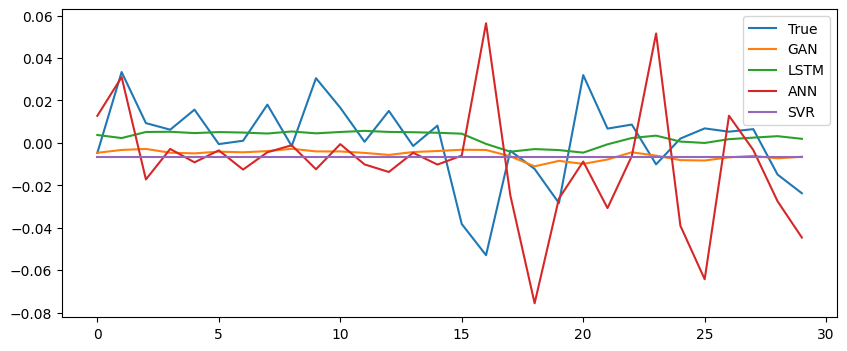

In [27]:
# Comparing predictions

L = 30

columns = ['True', 'GAN', 'LSTM', 'ANN', 'SVR']

z = zip(Y_test[..., 5], y_pred_GAN, y_pred_LSTM, y_pred_ANN, y_pred_SVR)
z = np.array(list(z))
models_predictions = z

w = z[-L:].reshape(L, len(columns))
w = w.T

plt.figure(figsize=(10, 4))
for i in range(len(columns)):
    plt.plot(w[i], label=columns[i])
plt.legend()
plt.show()


In [28]:
df = pd.DataFrame(data = models_predictions[-L:], columns = columns)
df.head(len(df))

,True,GAN,LSTM,ANN,SVR
0,-0.004753,-0.004645,0.003738,0.012754,-0.006807
1,0.033393,-0.003323,0.002285,0.031022,-0.006807
2,0.009327,-0.002837,0.005149,-0.017208,-0.006807
3,0.006231,-0.004633,0.005251,-0.002840,-0.006807
4,0.015668,-0.004928,0.004620,-0.009160,-0.006807
5,-0.000561,-0.004122,0.005101,-0.003521,-0.006807
6,0.001015,-0.004431,0.004882,-0.012563,-0.006807
7,0.018033,-0.003868,0.004425,-0.004414,-0.006807
8,-0.001496,-0.002777,0.005388,-0.001103,-0.006807
9,0.030505,-0.004002,0.004513,-0.012424,-0.006807
